# Code for the paper

Paper authors: Michela Paganini, Luke de Oliveira, Benjamin Nachman.

Paper title: Survey of Machine Learning Techniques for High Energy Electromagnetic Shower Classification

## Overview of the work

Team 2: Ivanov, Vasyutin, Korzun, Yangirov

We have implemented two baseline models described in the paper, although we sometimes deviated from the specific structural hyperparameters described there:
- Fully connected network on pixel intensities
- 3-stream convolutional network

We also implemented the proposed DenseNet, although we failed to find out the exact architecture used in the paper. We devised our own architecture, which, in particular, had additional fully-connected layers per calorimeter layer and overall.

We tried to do two improvements to these models:
- Augment the 3-stream convolutional network with the same structure of FC layers as used in our DenseNet
- Rescale the calorimeter layer images so that their sizes match, and run a DenseNet on them. This way, connections between layers can be formed very early in the network, which, according to our intuition, has a chance to achieve the same prediction quality with fewer parameters.

## Code

Setup work: import modules, initialize data loaders, select device, etc.

In [73]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import h5py
import tqdm.notebook
import sklearn.metrics
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Any

In [74]:
data = {
    'eplus': h5py.File('data/eplus_angle_position_5deg_xy.h5'),
    'piplus': h5py.File('data/piplus_angle_position_5deg_xy.h5'),
    'gamma': h5py.File('data/gamma_angle_position_5deg_xy.h5'),
}

In [75]:
if torch.cuda.is_available():
    print('Models will be run on a GPU (CUDA/HIP)')
    dev = torch.device('cuda')
else:
    print('Models will be run on a CPU')
    dev = torch.device('cpu')

Models will be run on a GPU (CUDA/HIP)


The sampler that will yield indices for minibatches. We do not perform shuffling, as it kills the performance of loading data from HDF5 files. Yet, we randomly pack sequential items from both samples into mini-batches.

In [76]:
def sample_sizes(size_a: int, size_b: int, num_samples: int) -> Tuple[int, int]:
    num_a_samples = min(
        np.random.binomial(num_samples, size_a / (size_a + size_b)),
        size_a,
    )
    num_b_samples = min(num_samples - num_a_samples, size_b)
    num_a_samples = min(num_samples - num_b_samples, size_a)
    assert num_a_samples + num_b_samples == min(num_samples, size_a + size_b)
    return num_a_samples, num_b_samples

class SamplerEpoch:
    def __init__(
        self,
        num_a_indices: int,
        num_b_indices: int,
        minibatch_size: int,
        id: Optional[int],
        cursor_a: int = 0,
        cursor_b: int = 0
    ) -> None:
        self.minibatch_size = minibatch_size
        self.id = id
        self.num_a_indices = num_a_indices
        self.num_b_indices = num_b_indices
        self.initial_cursor_a = cursor_a
        self.initial_cursor_b = cursor_b
        self.cursor_a = cursor_a
        self.cursor_b = cursor_b
    
    def __iter__(self) -> 'SamplerEpoch':
        return self

    def __next__(self):
        num_a_items_left = self.num_a_indices - self.cursor_a
        num_b_items_left = self.num_b_indices - self.cursor_b
        assert num_a_items_left >= 0
        assert num_b_items_left >= 0
        
        if num_a_items_left == num_b_items_left == 0:
            raise StopIteration()

        num_a_items, num_b_items = sample_sizes(
            num_a_items_left,
            num_b_items_left,
            self.minibatch_size,
        )
        
        begin_a = self.cursor_a
        end_a = begin_a + num_a_items
        begin_b = self.cursor_b
        end_b = begin_b + num_b_items
        
        self.cursor_a = end_a
        self.cursor_b = end_b
        # Only the last mini-batch may be incomplete.
        assert num_a_items + num_b_items == self.minibatch_size or (
            self.cursor_a == self.num_a_indices
            and self.cursor_b == self.num_b_indices
        )
        return (begin_a, end_a), (begin_b, end_b)
    
    def __len__(self):
        num_indices = self.num_a_indices + self.num_b_indices - self.initial_cursor_a - self.initial_cursor_b
        batch = self.minibatch_size
        return (num_indices + batch - 1) // batch
    
    def __repr__(self) -> str:
        return (
            f'SamplerEpoch(id={self.id}), '
            f'minibatch_size={self.minibatch_size}, '
            f'num_indices=({self.num_a_indices}, {self.num_b_indices}), '
            f'cursor=({self.cursor_a}, {self.cursor_b}))'
        )

class Sampler:
    def __init__(
        self,
        num_samples_a: int,
        num_samples_b: int,
        minibatch_size: int,
        cv_split: float,
    ) -> None:
        while True:
            num_cv_indices_a = round(num_samples_a * cv_split)
            num_cv_indices_b = round(num_samples_b * cv_split)
            self.cv_start_a = num_samples_a - num_cv_indices_a
            self.cv_start_b = num_samples_b - num_cv_indices_b
            if (self.cv_start_a + self.cv_start_b) % minibatch_size == 1:
                cv_split *= 0.9999
            else:
                break
        self.num_samples_a = num_samples_a
        self.num_samples_b = num_samples_b
        self.minibatch_size = minibatch_size
        self.num_epochs = 0
    
    def epoch(self) -> SamplerEpoch:
        self.num_epochs += 1
        return SamplerEpoch(
            self.cv_start_a,
            self.cv_start_a,
            minibatch_size=self.minibatch_size,
            id=self.num_epochs,
        )
    
    def cv(self) -> SamplerEpoch:
        return SamplerEpoch(
            self.num_samples_a,
            self.num_samples_b,
            minibatch_size=self.minibatch_size,
            id=None,
            cursor_a=self.cv_start_a,
            cursor_b=self.cv_start_b,
        )

    def __repr__(self) -> str:
        return (
            f'Sampler(cv_start=({self.cv_start_a}, {self.cv_start_b}), '
            f'num_samples=({self.num_samples_a}, {self.num_samples_b}), '
            f'minibatch_size={self.minibatch_size}, '
            f'self.num_epochs={self.num_epochs})'
        )

Some helper functions for data loading.

In [77]:
from functools import reduce

def get_layers(data_file: h5py.File, begin: int, end: int) -> List[np.ndarray]:
    layers = []
    for i in range(3):
        layer = data_file[f'layer_{i}']
        layer_part = layer[begin:end]
        layers.append(layer_part)
    return layers

def flatten_layers(data_file: h5py.File, begin: int, end: int) -> np.ndarray:
    layers = get_layers(data_file, begin, end)
    
    for i, layer in enumerate(layers):
        feature_size = reduce(lambda a, b: a * b, layer.shape[1:])
        reshaped = layer.reshape((layer.shape[0], feature_size))
        layers[i] = reshaped
        
    return np.hstack(layers)

Base class for models.

In [78]:
from abc import abstractmethod, ABC

class BaseModel(torch.nn.Module, ABC):
    @abstractmethod
    def prepare_input(
        self,
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        """Prepare input data from the dataset slices and return tensors `X` and `y` on `dev`."""
        ...
    
    @abstractmethod
    def description(self) -> str:
        """Briefly describe this model."""
        ...

Baseline 1: fully connected network on pixel intensities. Architecture copies the one described in the paper.

In [79]:
class ModelFcPixel(BaseModel):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            self.make_layer(504, 512),
            self.make_layer(512, 1024),
            self.make_layer(1024, 2048),
            self.make_layer(2048, 1024),
            self.make_layer(1024, 128),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_layer(num_in, num_out):
        return torch.nn.Sequential(
            torch.nn.Linear(num_in, num_out),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.BatchNorm1d(num_out),
        )
        
    def forward(self, x):
        return self.layers(x)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x_a = flatten_layers(data_a, begin_a, end_a)
        x_b = flatten_layers(data_b, begin_b, end_b)
        x = torch.Tensor(np.vstack([x_a, x_b])).to(dev)
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b)).to(dev)
        return x, y
    
    @staticmethod
    def description() -> str:
        return 'FC network on pixel intensities'

Helper module to ensure the tensor shape is as required.

In [80]:
class AssertShape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.required_shape = torch.Size(shape)
    
    def forward(self, x):
        actual_shape = x.shape[1:]
        if actual_shape != self.required_shape:
            raise ValueError(f'Invalid shape: expected {self.required_shape}, got {actual_shape}')
        return x

Helper function to move multiple tensors to GPU more efficiently.

In [81]:
from functools import reduce

def move_tensors_to(tensors, device):
    shapes = [tensor.shape for tensor in tensors]
    all_flat = torch.cat([tensor.flatten() for tensor in tensors], 0)
    all_flat = all_flat.to(device)
    sizes = [reduce(lambda a, b: a * b, shape) for shape in shapes]
    
    moved_tensors = []
    cumulative_size = 0
    for shape, size in zip(shapes, sizes):
        new_cumulative_size = cumulative_size + size
        flat_tensor = all_flat[cumulative_size:new_cumulative_size]
        moved_tensors.append(flat_tensor.view(*shape))
        cumulative_size = new_cumulative_size
    return moved_tensors

Helper module to concatenate the result of module execution channel-wise with the input instead of replacing it.

In [82]:
class ConcatResidual(torch.nn.Module):
    def __init__(self, inner: torch.nn.Module) -> None:
        super().__init__()
        self.inner = inner
    
    def forward(self, x):
        
        x_add = self.inner(x)
        assert len(x_add.shape) == len(x.shape)
        
        channel_axis = 1
        for i in range(len(x.shape)):
            if i != channel_axis and x_add.shape[i] != x.shape[i]:
                raise Exception(f'Concat shape mismatch: {x_add.shape} vs {x.shape}')
                
        return torch.cat([x, x_add], channel_axis)

Baseline 2: 3-stream convolutional neural network based on the CaloGAN paper.

Citation: Michela Paganini, Luke de Oliveira, Benjamin Nachman. CaloGAN: Simulating 3D High Energy Particle Showers in Multi-Layer Electromagnetic Calorimeters with Generative Adversarial Networks.

In [88]:
# Reference: https://github.com/hep-lbdl/CaloGAN/blob/v1.0/models/architectures.py.
# Paper: https://arxiv.org/abs/1712.10321.
class ModelConv3(BaseModel):
    def __init__(self):
        super().__init__()
        self.layers_0 = torch.nn.Sequential(
            AssertShape(1, 3, 96),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 3, 48),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 4, 49),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 5, 25),
            
            torch.nn.Flatten(),
            AssertShape(1000),
        )
        self.layers_1 = torch.nn.Sequential(
            AssertShape(1, 12, 12),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 6),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 7),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 4),
            
            torch.nn.Flatten(),
            AssertShape(448),
        )
        self.layers_2 = torch.nn.Sequential(
            AssertShape(1, 12, 6),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 3),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 4),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 3),
            
            torch.nn.Flatten(),
            AssertShape(336),
        )
        flat_size = 1000 + 448 + 336
        self.layers_post = torch.nn.Sequential(
            AssertShape(flat_size),
            torch.nn.Linear(flat_size, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_conv_layer(num_in, num_out, kernel=3, norm=True, padding='same', stride=1):
        return torch.nn.Sequential(
            torch.nn.Conv2d(num_in, num_out, kernel, padding=padding, stride=stride),
            torch.nn.LeakyReLU(),
            *([torch.nn.BatchNorm2d(num_out)] if norm else []),
        )
        
    def forward(self, x):
        x0, x1, x2 = x
        p0 = self.layers_0(x0)
        p1 = self.layers_1(x1)
        p2 = self.layers_2(x2)
        p = torch.cat((p0, p1, p2), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return '3-stream convolution network'

3-stream convolutional network augmented with additional fully-connected layers.

In [89]:
# Reference: https://github.com/hep-lbdl/CaloGAN/blob/v1.0/models/architectures.py.
# Paper: https://arxiv.org/abs/1712.10321.
class ModelConv3PlusFC(BaseModel):
    def __init__(self):
        super().__init__()
        self.layers_0 = torch.nn.Sequential(
            AssertShape(1, 3, 96),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 3, 48),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 4, 49),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 5, 25),
            
            torch.nn.Flatten(),
            AssertShape(1000),
            torch.nn.Linear(1000, 100),
            torch.nn.LeakyReLU(),
        )
        self.layers_1 = torch.nn.Sequential(
            AssertShape(1, 12, 12),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 6),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 7),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 4),
            
            torch.nn.Flatten(),
            AssertShape(448),
            torch.nn.Linear(448, 80),
            torch.nn.LeakyReLU(),
        )
        self.layers_2 = torch.nn.Sequential(
            AssertShape(1, 12, 6),
            self.make_conv_layer(1, 64, kernel=3, norm=False),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(64, 16, kernel=3, padding='valid', stride=(1, 2)),
            AssertShape(16, 12, 3),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(16, 8, kernel=2, padding='valid'),
            AssertShape(8, 13, 4),
            
            torch.nn.ZeroPad2d(1),
            self.make_conv_layer(8, 8, kernel=2, padding='valid', stride=(1, 2)),
            AssertShape(8, 14, 3),
            
            torch.nn.Flatten(),
            AssertShape(336),
            torch.nn.Linear(336, 80),
            torch.nn.LeakyReLU(),
        )
        flat_size = 100 + 80 + 80
        self.layers_post = torch.nn.Sequential(
            AssertShape(flat_size),
            torch.nn.Linear(flat_size, 300),
            torch.nn.BatchNorm1d(300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_conv_layer(num_in, num_out, kernel=3, norm=True, padding='same', stride=1):
        return torch.nn.Sequential(
            torch.nn.Conv2d(num_in, num_out, kernel, padding=padding, stride=stride),
            torch.nn.LeakyReLU(),
            *([torch.nn.BatchNorm2d(num_out)] if norm else []),
        )
        
    def forward(self, x):
        x0, x1, x2 = x
        p0 = self.layers_0(x0)
        p1 = self.layers_1(x1)
        p2 = self.layers_2(x2)
        p = torch.cat((p0, p1, p2), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return '3-stream convolution network + FC layers'

Three-stream DenseNet augmented with additional FC layers.

In [90]:
# Paper: https://arxiv.org/abs/1608.06993
class ModelDenseNet3(BaseModel):
    def __init__(self):
        super().__init__()
        
        # Growth rate.
        k = self.k = 8
        
        self.layers_0 = torch.nn.Sequential(
            AssertShape(1, 3, 96),
            self.make_densenet_layer(1, k - 1),
            
            self.make_densenet_layer(k, k),
            self.make_transition_layer(2 * k, stride=(1, 2)),
            AssertShape(2 * k, 3, 48),
            
            self.make_densenet_layer(2 * k, k),
            self.make_transition_layer(3 * k, stride=(1, 2)),
            AssertShape(3 * k, 3, 24),
            
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=(1, 2)),
            AssertShape(4 * k, 3, 12),
            
            torch.nn.Flatten(),
            AssertShape(144 * k),
            torch.nn.Linear(144 * k, 100),
            torch.nn.LeakyReLU(),
        )
        
        self.layers_1 = torch.nn.Sequential(
            AssertShape(1, 12, 12),
            self.make_densenet_layer(1, k - 1),
            
            self.make_densenet_layer(k, k),
            self.make_transition_layer(2 * k, stride=2),
            AssertShape(2 * k, 6, 6),
            
            self.make_densenet_layer(2 * k, k),
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=2),
            AssertShape(4 * k, 3, 3),
            
            torch.nn.Flatten(),
            AssertShape(36 * k),
            torch.nn.Linear(36 * k, 80),
            torch.nn.LeakyReLU(),
        )
        
        self.layers_2 = torch.nn.Sequential(
            AssertShape(1, 12, 6),
            self.make_densenet_layer(1, k - 1),
            
            self.make_densenet_layer(k, k),
            self.make_transition_layer(2 * k, stride=(2, 1)),
            AssertShape(2 * k, 6, 6),
            
            self.make_densenet_layer(2 * k, k),
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=2),
            AssertShape(4 * k, 3, 3),
            
            torch.nn.Flatten(),
            AssertShape(36 * k),
            torch.nn.Linear(36 * k, 80),
            torch.nn.LeakyReLU(),
        )
        
        flat_size = 100 + 80 + 80
        self.layers_post = torch.nn.Sequential(
            AssertShape(flat_size),
            torch.nn.Linear(flat_size, 300),
            torch.nn.BatchNorm1d(300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 1),
            torch.nn.Sigmoid(),
        )
    
    def make_densenet_layer(self, num_in, num_add, kernel=3):
        submodule = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_in),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(num_in, num_add, kernel, padding='same'),
        )
        return ConcatResidual(submodule)
    
    def make_transition_layer(self, num_channels, stride):
        return torch.nn.AvgPool2d(stride)
        
    def forward(self, x):
        x0, x1, x2 = x
        p0 = self.layers_0(x0)
        p1 = self.layers_1(x1)
        p2 = self.layers_2(x2)
        p = torch.cat((p0, p1, p2), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return '3-stream DenseNet + FC layers'

Single-stream DenseNet model on layers upscaled in such a way that their sizes match.
Tries to exploit spatial locality of layers, like a regular ConvNet. Forms interconnections between calorimeter layers from the very beginning, which might be more efficient than delaying it to the last FC stage.

In [91]:
class ModelDenseNetJoin(BaseModel):
    def __init__(self):
        super().__init__()
        
        # Growth rate.
        k = self.k = 8
        
        # Use both upsampling modes to achieve an approximation of position encoding.
        self.upsample_bilinear = torch.nn.Upsample(size=(12, 96), mode='bilinear')
        self.upsample_nearest = torch.nn.Upsample(size=(12, 96), mode='nearest')
        
        self.layers_post = torch.nn.Sequential(
            AssertShape(6, 12, 96),
            self.make_densenet_layer(6, k - 6),
            self.make_densenet_layer(k, k),
            
            self.make_densenet_layer(2 * k, k),
            self.make_transition_layer(3 * k, stride=(1, 2)),
            AssertShape(3 * k, 12, 48),
            
            self.make_densenet_layer(3 * k, k),
            self.make_transition_layer(4 * k, stride=2),
            AssertShape(4 * k, 6, 24),
            
            self.make_densenet_layer(4 * k, k),
            self.make_transition_layer(5 * k, stride=2),
            AssertShape(5 * k, 3, 12),
            
            self.make_densenet_layer(5 * k, k),
            self.make_transition_layer(6 * k, stride=(1, 2)),
            AssertShape(6 * k, 3, 6),
            
            torch.nn.Flatten(),
            AssertShape(108 * k),
            
            torch.nn.Linear(108 * k, 250),
            torch.nn.BatchNorm1d(250),
            torch.nn.LeakyReLU(),
            
            torch.nn.Linear(250, 1),
            torch.nn.Sigmoid(),
        )
    
    def make_densenet_layer(self, num_in, num_add, kernel=3):
        submodule = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_in),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(num_in, num_add, kernel, padding='same'),
        )
        return ConcatResidual(submodule)
    
    def make_transition_layer(self, num_channels, stride):
        return torch.nn.AvgPool2d(stride)
        
    def forward(self, x):
        x0, x1, x2 = x
        p0a = self.upsample_bilinear(x0)
        p0b = self.upsample_nearest(x0)
        p1a = self.upsample_bilinear(x1)
        p1b = self.upsample_nearest(x1)
        p2a = self.upsample_bilinear(x2)
        p2b = self.upsample_nearest(x2)
        p = torch.cat((p0a, p0b, p1a, p1b, p2a, p2b), 1)
        return self.layers_post(p)

    @staticmethod
    def prepare_input(
        data_a: h5py.File,
        data_b: h5py.File,
        begin_a: int,
        end_a: int,
        begin_b: int,
        end_b: int,
    ) -> Tuple[Any, torch.Tensor]:
        x0_a, x1_a, x2_a = get_layers(data_a, begin_a, end_a)
        x0_b, x1_b, x2_b = get_layers(data_b, begin_b, end_b)
        
        y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b))
        x0 = torch.Tensor(np.vstack([x0_a, x0_b]))
        x1 = torch.Tensor(np.vstack([x1_a, x1_b]))
        x2 = torch.Tensor(np.vstack([x2_a, x2_b]))
        x0, x1, x2, y = move_tensors_to([x0, x1, x2, y], dev)
        
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 3
        x0 = x0.view(x0.shape[0], 1, x0.shape[1], x0.shape[2])
        x1 = x1.view(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        x2 = x2.view(x2.shape[0], 1, x2.shape[1], x2.shape[2])
        assert len(x0.shape) == len(x1.shape) == len(x2.shape) == 4
        
        x = (x0, x1, x2)
        return x, y
    
    @staticmethod
    def description() -> str:
        return 'Single-stream DenseNet'

Training infrastructure.

In [92]:
def train_and_evaluate(
    model,
    alt_label,
    num_epochs,
    minibatch_size=128,
    cv_split=0.1,
):
    data_a = data['eplus']
    data_b = data[alt_label]
    sampler = Sampler(
        len(data_a['layer_0']),
        len(data_b['layer_0']),
        minibatch_size=minibatch_size,
        cv_split=cv_split,
    )
    opt = torch.optim.Adam(model.parameters())
    
    max_train_index_a = 0
    max_train_index_b = 0
    model.train()
    while True:
        epoch = sampler.epoch()
        if epoch.id > num_epochs:
            break

        print(f':: Epoch {epoch.id}', flush=True)
        for (begin_a, end_a), (begin_b, end_b) in tqdm.notebook.tqdm(epoch):
            assert begin_a <= end_a
            assert begin_b <= end_b
            
            max_train_index_a = max([max_train_index_a, end_a-1])
            max_train_index_b = max([max_train_index_b, end_b-1])
            opt.zero_grad()
            x, y = model.prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b)
            y_prob = model(x).flatten()
            loss = F.binary_cross_entropy(y_prob, y)
            loss.backward()
            opt.step()
    
    print(':: Evaluating')
    model.eval()
    y = []
    y_prob = []
    with torch.no_grad():
        for (begin_a, end_a), (begin_b, end_b) in tqdm.notebook.tqdm(sampler.cv()):
            assert max_train_index_a < begin_a <= end_a
            assert max_train_index_b < begin_b <= end_b
            x, this_y = model.prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b)
            this_y_prob = model(x).flatten().cpu()
            y += list(this_y.cpu())
            y_prob += list(this_y_prob)
    
    return model, y, y_prob

In [93]:
def count_parameters(model: torch.nn.Module):
    # https://stackoverflow.com/a/49201237
    return sum(param_set.numel() for param_set in model.parameters())

In [94]:
def format_big_number(num: int) -> str:
    it = iter(reversed(str(num)))
    result = []
    
    while True:
        try:
            for _ in range(3):
                result.append(next(it))
            result.append(' ')
        except StopIteration:
            break
        
    if result[-1] == ' ':
        result.pop()
    return f''.join(reversed(result))

Train models on the eplus–piplus task:

In [95]:
models = [
    ModelConv3().to(dev),
    ModelDenseNetJoin().to(dev),
    ModelDenseNet3().to(dev),
    ModelConv3PlusFC().to(dev),
    ModelFcPixel().to(dev),
]
num_epochs = 1
alt_label = 'piplus'

results = {}
for model in models:
    print(f'Model: {model.description()}')
    print(f'Parameters: {format_big_number(count_parameters(model))}')
    _, y, y_prob = train_and_evaluate(
        model=model,
        alt_label=alt_label,
        num_epochs=num_epochs,
    )
    results[model.__class__.__name__] = (y, y_prob)

Model: 3-stream convolution network
Parameters: 33 945
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: Single-stream DenseNet
Parameters: 226 043
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: 3-stream DenseNet + FC layers
Parameters: 251 685
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: 3-stream convolution network + FC layers
Parameters: 274 341
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: FC network on pixel intensities
Parameters: 5 122 049
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

ROC curves in a modified space (true positive rate, 1 / false positive rate). This corresponds to the space used in the paper and is used for readability.

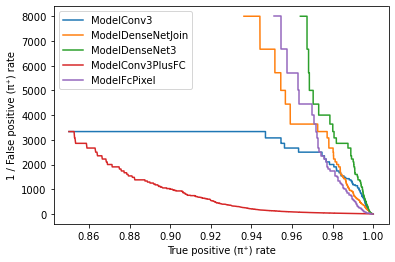

In [96]:
fpr_threshold = 1/10000
tpr_threshold = 0.85

labels = []
handles = []

for name, (y, y_prob) in results.items():
    fpr, tpr, _ = sklearn.metrics.roc_curve(y, y_prob)
    mask = (fpr > fpr_threshold) & (tpr > tpr_threshold)
    handles += plt.plot(tpr[mask], 1/fpr[mask])
    labels.append(name)

plt.xlabel('True positive (π⁺) rate')
plt.ylabel('1 / False positive (π⁺) rate')
plt.legend(handles=handles, labels=labels)
plt.show()

In [97]:
for name, (y, y_prob) in results.items():
    auc = sklearn.metrics.roc_auc_score(y, y_prob)
    print(f'{name:20} ROC AUC = {auc:.7f}; 1/(1-ROC AUC) = {1/(1-auc):.7f}')

ModelConv3           ROC AUC = 0.9996898; 1/(1-ROC AUC) = 3223.3005953
ModelDenseNetJoin    ROC AUC = 0.9997454; 1/(1-ROC AUC) = 3927.2708707
ModelDenseNet3       ROC AUC = 0.9997732; 1/(1-ROC AUC) = 4410.0460850
ModelConv3PlusFC     ROC AUC = 0.9977887; 1/(1-ROC AUC) = 452.2249240
ModelFcPixel         ROC AUC = 0.9995361; 1/(1-ROC AUC) = 2155.8240395


Note: ModelConv3PlusFC initially yielded results much better than what is displayed currently, being very close in performance to ModelDenseNet3 (i.e. the difference in 1 / (1 - ROC AUC) was on the order of a few hundreds). Currently, however, this is not the case. We attribute it to a bug, but unfortunately we did not have enough time to locate and fix it. We draw conclusions based on our initial observations, as the bug only occurred.

In [98]:
models = [
    ModelConv3().to(dev),
    ModelDenseNetJoin().to(dev),
    ModelDenseNet3().to(dev),
    ModelConv3PlusFC().to(dev),
    ModelFcPixel().to(dev),
]
num_epochs = 1
alt_label = 'gamma'

results = {}
for model in models:
    print(f'Model: {model.description()}')
    print(f'Parameters: {format_big_number(count_parameters(model))}')
    _, y, y_prob = train_and_evaluate(
        model=model,
        alt_label=alt_label,
        num_epochs=num_epochs,
    )
    results[model.__class__.__name__] = (y, y_prob)

Model: 3-stream convolution network
Parameters: 33 945
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: Single-stream DenseNet
Parameters: 226 043
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: 3-stream DenseNet + FC layers
Parameters: 251 685
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: 3-stream convolution network + FC layers
Parameters: 274 341
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

Model: FC network on pixel intensities
Parameters: 5 122 049
:: Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

:: Evaluating


  0%|          | 0/704 [00:00<?, ?it/s]

ROC curves:

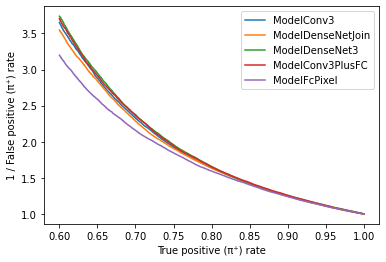

In [101]:
fpr_threshold = 1/10000
tpr_threshold = 0.6

labels = []
handles = []

for name, (y, y_prob) in results.items():
    fpr, tpr, _ = sklearn.metrics.roc_curve(y, y_prob)
    mask = (fpr > fpr_threshold) & (tpr > tpr_threshold)
    handles += plt.plot(tpr[mask], 1/fpr[mask])
    labels.append(name)

plt.xlabel('True positive (π⁺) rate')
plt.ylabel('1 / False positive (π⁺) rate')
plt.legend(handles=handles, labels=labels)
plt.show()

In [100]:
for name, (y, y_prob) in results.items():
    auc = sklearn.metrics.roc_auc_score(y, y_prob)
    print(f'{name:20} ROC AUC = {auc:.7f}; 1/(1-ROC AUC) = {1/(1-auc):.7f}')

ModelConv3           ROC AUC = 0.7149358; 1/(1-ROC AUC) = 3.5079820
ModelDenseNetJoin    ROC AUC = 0.7130667; 1/(1-ROC AUC) = 3.4851310
ModelDenseNet3       ROC AUC = 0.7194775; 1/(1-ROC AUC) = 3.5647765
ModelConv3PlusFC     ROC AUC = 0.7184211; 1/(1-ROC AUC) = 3.5514029
ModelFcPixel         ROC AUC = 0.6952983; 1/(1-ROC AUC) = 3.2818987


## Results
- The performance of the 3-stream convolutional neural network model on both eplus–piplus and eplus–gamma classification tasks can be improved by augmenting it with additional FC layers (both per-stream and overall). This introduces a lot more parameters but does not impact training and inference speed very much.
- DenseNet with FC layers still performs better, although only slightly, than the ConvNet with the comparable FC layer structure and number of parameters.
- Our attempt to improve DenseNet by upscaling calorimeter layer images and merging them together failed. Our assumption is that individual layers are quite self-sufficient in classification and do not benefit much from interaction all through the network.